In [23]:
import glob
import importlib
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
import pandas as pd
import mediapipe as mp
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#Pseudo code classifier
import poseclassifier

In [ ]:
importlib.reload(poseclassifier)

In [3]:

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

training_images = []
for folder in os.listdir():
    pics = {}
    pics[folder] = [file for file in glob.glob(folder + '/*.png')]
    if len(pics[folder]) != 0:
        training_images.append(pics)

In [4]:
training_images[0]

{'1-right-ear': ['1-right-ear\\1.PNG',
  '1-right-ear\\2.PNG',
  '1-right-ear\\3.PNG',
  '1-right-ear\\33.PNG',
  '1-right-ear\\333.PNG',
  '1-right-ear\\4.PNG',
  '1-right-ear\\44.PNG',
  '1-right-ear\\5.PNG',
  '1-right-ear\\6.PNG',
  '1-right-ear\\66.PNG',
  '1-right-ear\\7.PNG',
  '1-right-ear\\9.PNG',
  '1-right-ear\\99.PNG',
  '1-right-ear\\999.PNG']}

In [6]:
def read_image_pose(x, pose_image = mp_pose.Pose(static_image_mode=True)):
    image = cv2.imread(x)
    results = pose_image.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    image = cv2.resize(image, (128, 320))
    return image

def read_pose_landmark(x, pose_image = mp_pose.Pose(static_image_mode=True)):
    image = cv2.imread(x)
    results = pose_image.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    landmark_array = []
    for lm in results.pose_landmarks.landmark:
        cx, cy = float(lm.x), float(lm.y)
        landmark_array.append([cx, cy])
    return np.stack(landmark_array)

In [7]:
array = []
label = []
for i in training_images:
    for key in i.keys():
        for j in i[key]:
            array.append(read_image_pose(j))
            label.append(key)

In [8]:
train_data = np.array(array)
train_label = np.vstack(label)#To match the shape of the training data

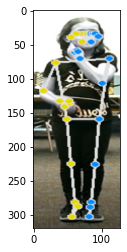

In [25]:
plt.imshow(train_data[0])

In [9]:
onehot = OneHotEncoder(sparse=False)

In [59]:
'''
x: Normalizing the data, to reduce the range of our values
   So we divide by the max train_data.max() = 255
y: Converting object type variables to sparse categorical
'''
x = train_data
y = onehot.fit_transform(train_label)
x.shape, y.shape

((82, 320, 128, 3), (82, 8))

In [60]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [12]:
y_test

array([[0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.]])

In [64]:
cnn = keras.models.Sequential([
    Conv2D(64, 3, 3, activation='relu', input_shape=x_train.shape[1:]),
    MaxPool2D(pool_size=(2, 2)),
    keras.layers.Input(shape=x_train.shape[1:]),
    Flatten(),
    Dense(200),
    #Dropout(0.2),
    Dense(100, activation='relu'),
    Dense(8, activation='softmax')
])
cnn.compile(optimizer=keras.optimizers.Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [65]:
history = cnn.fit(x_train, y_train, epochs=10)

Epoch 1/10
3/3 [==============================] - 6s 869ms/step - loss: 1846.2256 - accuracy: 0.1233
Epoch 2/10
3/3 [==============================] - 3s 880ms/step - loss: 5511.9810 - accuracy: 0.2329
Epoch 3/10
3/3 [==============================] - 3s 770ms/step - loss: 6760.6440 - accuracy: 0.1096
Epoch 4/10
3/3 [==============================] - 2s 710ms/step - loss: 2801.9207 - accuracy: 0.1918
Epoch 5/10
3/3 [==============================] - 2s 755ms/step - loss: 586.1552 - accuracy: 0.1644
Epoch 6/10
3/3 [==============================] - 3s 791ms/step - loss: 702.0736 - accuracy: 0.3699
Epoch 7/10
3/3 [==============================] - 3s 909ms/step - loss: 747.2745 - accuracy: 0.3562
Epoch 8/10
3/3 [==============================] - 3s 890ms/step - loss: 349.3224 - accuracy: 0.4658
Epoch 9/10
3/3 [==============================] - 3s 974ms/step - loss: 66.1158 - accuracy: 0.7671
Epoch 10/10
3/3 [==============================] - 3s 854ms/step - loss: 68.7952 - accuracy: 0.76

In [66]:
y_preds = []
for i in cnn.predict(x_test):
    empty_arr = np.zeros(8)
    empty_arr[np.argmax(i)] = 1
    y_preds.append(empty_arr)
accuracy_score(y_test, y_preds)

0.4444444444444444

In [77]:
'''
Initialize pose detection algorithm
Using index finger as end point for hand
'''
pose_clf = poseclassifier.PoseClassifier(threshold=0.14, point='index_1')

In [78]:
y_preds = []
for i in training_images:
    for key in i.keys():
        for j in i[key]:
            landmark_array = read_pose_landmark(j)
            y_preds.append(pose_clf.determine_pose(landmark_array))

In [79]:
accuracy_score(y, y_preds)

0.8414634146341463